# To do

### **Coding**

1.自己implement VD的话，要用histogram和vd先segment face

2.opencv的话，现在做好了dt，下一步是eye detection，algorithm 参考paper

### **Writing**

1.   History and background of Voronoi Diagrams

2.   Algorithms for constructing Voronoi Diagrams
2.   Duality with Delauanay Triangulations（definition, why and how duality）

3.   Related work section: 一人一段
4.   Overall check for consistent style


# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Geopandas

     |████████████████████████████████| 1.0MB 7.7MB/s 
     |████████████████████████████████| 6.5MB 27.2MB/s 
     |████████████████████████████████| 15.3MB 241kB/s 


In [ ]:
pip install opencv-contrib-python==4.1.2.30

In [ ]:
import matplotlib.pylab as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import scipy.ndimage as ndimage
from PIL import Image
from shapely.geometry import Point

import cv2

import dlib
import random

from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt

from shapely.geometry.polygon import Polygon
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import os
import glob
from scipy.spatial.distance import pdist, squareform
import time

# Load dataset and labeling

In [ ]:
# images in dir
def load_img(masked_dir, unmasked_dir, size):
  image_dirs = os.listdir(masked_dir)

  images = []
  count_mask = 0
  for i in range(size):
    img = cv2.imread(os.path.join(masked_dir,image_dirs[i]))
    if img is not None:
      images.append(img)
      count_mask = count_mask+1

  image_dirs = os.listdir(unmasked_dir)
  for i in range(size):
    img = cv2.imread(os.path.join(unmasked_dir,image_dirs[i]))
    if img is not None:
      images.append(img)
  return images, count_mask

def get_labels(images, count_mask): 
  labels = []
  for i in range(count_mask):
    labels.append(1)
  for i in range(count_mask, len(images)):
    labels.append(0)  
  return labels

In [ ]:
masked_dir = '/content/drive/MyDrive/Voronoi Diagram/rmfd/masked'
unmasked_dir = '/content/drive/MyDrive/Voronoi Diagram/rmfd/unmasked'

#masked_dir = '/content/drive/MyDrive/rmfd/masked'
#unmasked_dir = '/content/drive/MyDrive/rmfd/unmasked'
images, count_mask = load_img(masked_dir, unmasked_dir, 500)
labels = get_labels(images, count_mask)

In [ ]:
print(len(labels))

1000


# Accuracy Method: compute_accuracy()

In [ ]:
# predicted is a list of predicted labels, and labels are correct labels 
def compute_accuracy(predicted, labels):
  num_correct = 0
  for i in range(len(predicted)):
    if predicted[i] == labels[i]:
      num_correct += 1
  num_instances = len(labels)
  accuracy = num_correct / num_instances
  return accuracy

# Binary: to_binary()

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")
#img = images[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_binary(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  (thresh, im_bw) = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return im_bw

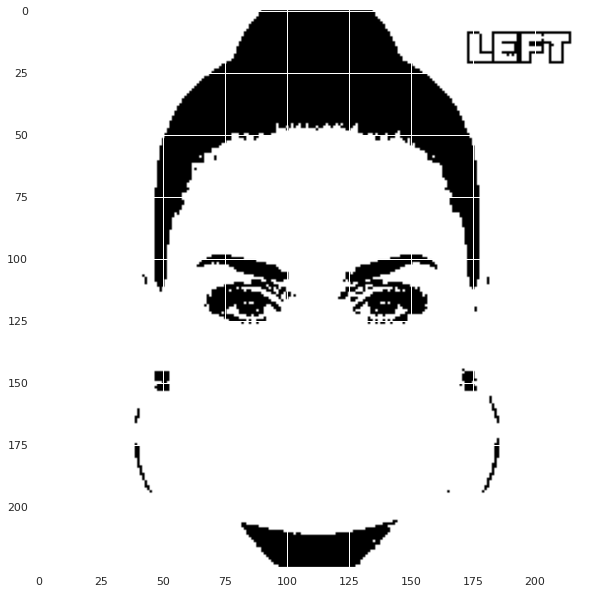

In [ ]:
img_binary = to_binary(images[5])
fig = plt.figure()
fig.set_size_inches(10,20)
plt.imshow(img_binary,cmap = 'gray')
plt.show()

# Face Segmentation

## A.face shape

Use OpenCV to detect face and do Delaunary Triangulazation

cited from https://pysource.com/2019/04/04/face-swapping-opencv-with-python-part-1/

https://pysource.com/2019/04/19/delaunay-triangulation-for-face-swapping-opencv-with-python-part-2/


In [ ]:
def extract_points(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("/content/drive/MyDrive/Voronoi Diagram/shape_predictor_68_face_landmarks.dat")
  faces = detector(img_gray)
  landmarks_points = []
  points = []
  for face in faces:
      landmarks = predictor(img_gray, face)
      for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append(Point(x, y))          
        landmarks_points.append((x, y))
  landmarks_points = np.array(landmarks_points, np.int32)
  return landmarks_points, points

def extract_face(img, plot, points):
  img_seg = img
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  mask = np.zeros_like(img_gray)
  if (len(points) == 0):
    return img, 2
  convexhull = cv2.convexHull(points)
      #cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
  cv2.fillConvexPoly(mask, convexhull, 255)
  img_seg = cv2.bitwise_and(img, img, mask=mask)
  if(plot):
    cv2_imshow(img_seg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
  return img_seg, 1

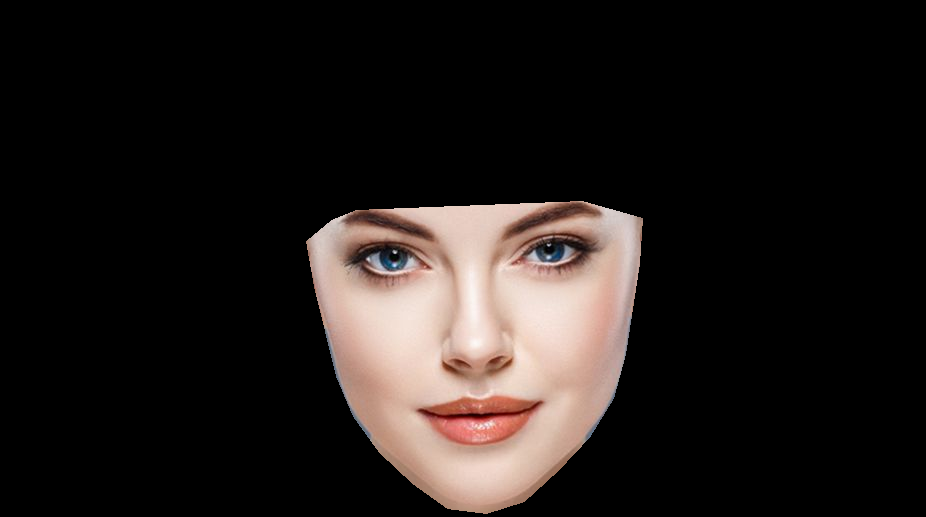

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")
pts, pts_2 = extract_points(img)
face_img, detected = extract_face(img,True, pts)

## B. Square

In [ ]:
def extract_square(imi_img, detected, tol=0):
    if detected == 2:
      return False, None
    else: 
      mask = imi_img>tol
      if imi_img.ndim==3:
          mask = mask.all(2)
      m,n = mask.shape
      mask0,mask1 = mask.any(0),mask.any(1)
      col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
      # row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
      row_start = mask1.argmax()
      row_end = row_start+(col_end-col_start)
      return True, imi_img[row_start:row_end,col_start:col_end]

In [ ]:
pts, pts_2 = extract_points(images[0])
imi_img, detected = extract_face(img,False, pts)
ifDetected, test_crop = extract_square(imi_img, detected)

# cv2_imshow(test_crop)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## C. different seg

In [ ]:
def detect_facemarks(i):
  retval, faces = cv2.face.getFacesHAAR(i, cv2.data.haarcascades +"haarcascade_frontalface_default.xml")

  #face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  #face_cascade = cv2.CascadeClassifier('lbpcascade_frontalcatface.xml')
  test_img = i
  #gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
  #faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  #facemark = cv2.face.createFacemarkLBF()
  #facemark.loadModel("/content/drive/MyDrive/Voronoi Diagram/lbfmodel.yaml")

  facemark = cv2.face.createFacemarkKazemi()
  facemark.loadModel("/content/drive/MyDrive/Voronoi Diagram/face_landmark_model.dat")

  if faces is None or len(faces)==0: 
    return []
  else: 
    ok, shapes = facemark.fit(i, faces)
    return np.array(shapes[0], np.int32)

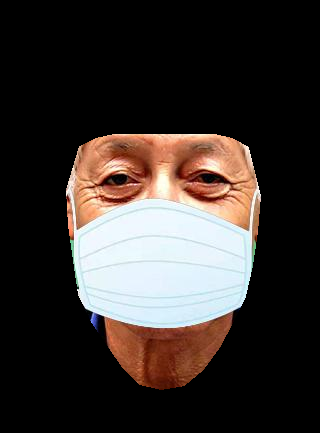

1


In [ ]:
img = images[4]
# cv2_imshow(img)
landmarks = detect_facemarks(img)
face_img, detected = extract_face(img,True,landmarks)
print(detected)

# seg accuracy

In [ ]:
fail_mask = 0
fail_um = 0
import time
start = time.time()

for i in range(len(images)):
  landmarks = detect_facemarks(images[i])
  if len(landmarks) == 0:
    if labels[i] ==1:
      fail_mask += 1
    else:
      fail_um += 1

end = time.time()
A = fail_mask+fail_um
print(A,"Acc:    ", (len(images)-A)/len(images))
print("Time consumed in working: ",end - start)
print("Masked undetected: ", fail_mask)
print("Unmasked undetected: ", fail_um)

205 Acc:     0.795
Time consumed in working:  280.23871970176697
Masked undetected:  167
Unmasked undetected:  38


In [ ]:
B=0
start = time.time()

for img in images:
  pts, pts_2 = extract_points(img)
  if len(pts) == 0: 
    B+= 1

end = time.time()
print(B,"Acc:    ", (len(images)-B)/len(images))
print("Time consumed in working: ",end - start)

KeyboardInterrupt: ignored

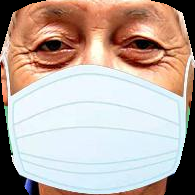

In [ ]:
def extract_face_final(orig_img):
  landmarks = detect_facemarks(orig_img)
  face_img, detected = extract_face(orig_img,False,landmarks)
  ifDetected, test_crop = extract_square(face_img, detected)
  return ifDetected, test_crop

img = images[4]
ifDetected, test_crop = extract_face_final(img)
cv2_imshow(test_crop)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Edge Detection and plot VD, Delaunay


## select points and plot function: select_plot()

In [ ]:
def select_plot(edge_point, thresh, plot):
  selected_points = []
  tri_points = []
  for i in range(edge_point.shape[0]):
    for j in range(edge_point.shape[1]):
      prob = np.random.rand()
      if edge_point[i][j] != 0 and prob >thresh:
        selected_points.append([j,edge_point.shape[0]-i])
        tri_points.append([j,i])
  selected_points = np.array(selected_points)

  if (plot):
    print('Vornoi Diagram: ')
    vor = Voronoi(selected_points)
    vor.close()
    fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=1)
    plt.show()
    fig.clear()

    print('Delaunay Triangle: ')
    tri = Delaunay(selected_points)
    plt.triplot(selected_points[:,0], selected_points[:,1], tri.simplices)
    #plt.plot(selected[:,0], selected[:,1])
    
    plt.show()
  else:
    return Delaunay(selected_points)

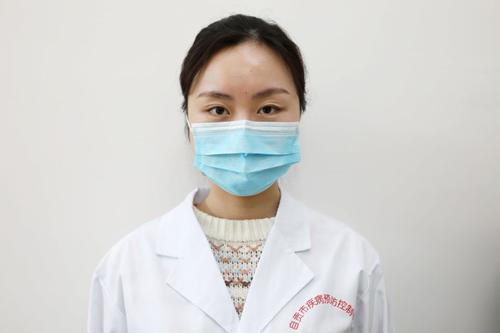

Vornoi Diagram: 


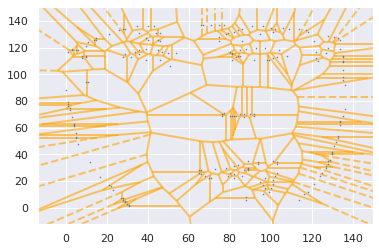

Delaunay Triangle: 


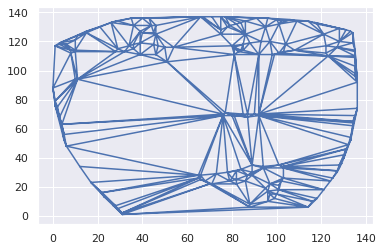

In [ ]:
  img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/1.jpg")
  # img=images[492]
  cv2_imshow(img)
  if_detected, croped = extract_face_final(img)
  edges = edge_A(croped)
  DT = select_plot(edges, 0.75, True)

## cv2.Canny: edge_A()

In [ ]:
def edge_A(img_seg):
  img_gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
  (thresh, im_bw) = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  edges = cv2.Canny(im_bw,1,2)
  return edges

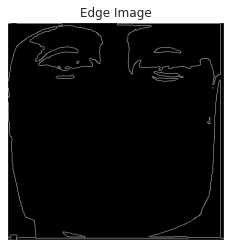

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/testB.png")

edges = edge_A(img)
fig = plt.figure()
#fig.set_size_inches(10,20)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

Vornoi Diagram: 


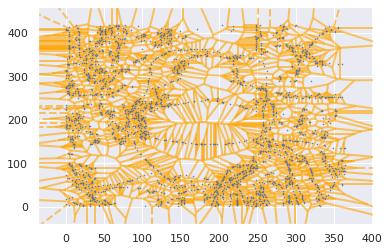

Delaunay Triangle: 


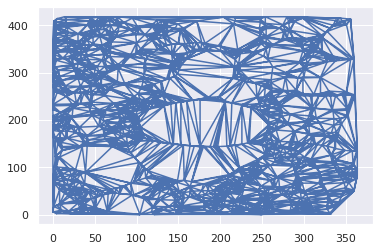

In [ ]:
select_plot(edges, 0.75, True)

cited from https://evergreenllc2020.medium.com/fundamentals-of-image-gradients-and-edge-detection-b093662ade1b


## Canny with Auto thres

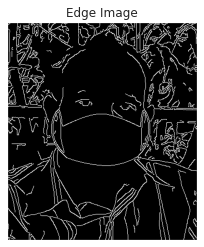

Vornoi Diagram: 


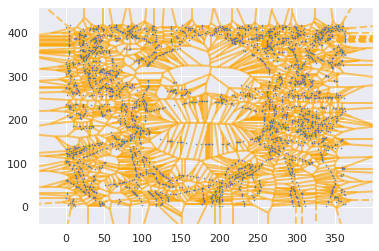

Delaunay Triangle: 


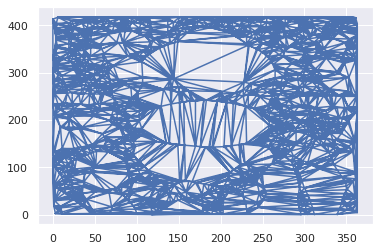

In [ ]:
def auto_canny(image, sigma=0.33):
 # compute the median of the single channel pixel intensities
 v = np.median(image)
 # apply automatic Canny edge detection using the computed median
 lower = int(max(0, (1.0 - sigma) * v))
 upper = int(min(255, (1.0 + sigma) * v))
 edged = cv2.Canny(image, lower, upper)
 # return the edged image
 return edged

def auto_edge(img): 
# loop over the images
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (3, 3), 0)
  auto = auto_canny(blurred)
  return auto

edges = auto_edge(images[0])
fig = plt.figure()
#fig.set_size_inches(10,20)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
select_plot(edges, 0.75, True)

## Sobel: edge_B()

In [ ]:
def edge_B(img_seg):
  #img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/1.png")
  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # compute the gradient magnitude and orientation respectively
  # compute gradients along the X and Y axis, respectively
  img_seg_binary = to_binary(img_seg)
  gX = cv2.Sobel(img_seg_binary, ddepth=cv2.CV_64F, dx=1, dy=0)
  gY = cv2.Sobel(img_seg_binary, ddepth=cv2.CV_64F, dx=0, dy=1)
  mag = np.sqrt((gX ** 2) + (gY ** 2)) 

  #cv2.imshow("gradient magnitude", mag)
  mag = np.array([point for point in mag if point.any() > 0.8])
  return mag

In [ ]:
edges = edge_B(face_img)
cv2_imshow(edges)

In [ ]:
select_plot(edges, 0.75,True)

# Eye Detection

## A.Eye Model

Prepare Data

In [ ]:
def generate_df(tri):
  eye_area = 200
  coord_groups = [tri.points[x] for x in tri.simplices]
  polygons = [Polygon(x) for x in coord_groups]
  first = []

  for each in polygons:
    if each.area < eye_area:
      first.append(each)

  main_df = gpd.GeoDataFrame(geometry=first)

    # preparation for kmeans
  main_df['x'] = main_df['geometry'].centroid.x
  main_df['y'] = main_df['geometry'].centroid.y
  coords = main_df[["x", "y"]].to_numpy()
  return main_df,coords


In [ ]:
tri = select_plot(edges, 0.75, False)
main_df, coords = generate_df(tri)
main_df

### DBSCAN clustering

In [ ]:
def dbscan_cluster(df,eps, min_sample,coords):
  # dbscan
  dbscan = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
  clusters = dbscan.fit(coords)
  labels = pd.Series(clusters.labels_).rename('cluster_label')
  df = pd.concat([df, labels], axis=1)  
  df = df.loc[:,~df.columns.duplicated()]

  return df

In [ ]:
db_df = dbscan_cluster(main_df,10, 2, coords)
db_df[db_df['cluster_label'] >= 0].cluster_label.drop_duplicates()

For tuning parameters in DBSCAN

In [ ]:
def tuning_dbscan(df):

  res = []
  eps = [1,5,10]
  sps = [2, 10, 200]
  for ep in eps:
    for min_samples in sps:
      dbscan = DBSCAN(eps=ep, min_samples=min_samples, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
      cluster = dbscan.fit(coords)
      n_clusters = len([i for i in set(cluster.labels_) if i != -1])
      outliners = np.sum(np.where(cluster.labels_ == -1, 1,0))
      stats = str(pd.Series([i for i in cluster.labels_ if i != -1],dtype=int).value_counts().values)
      res.append({'eps':ep,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})
  df = pd.DataFrame(res)


  return df.loc[(df['n_clusters'] != 0)].drop_duplicates()
tuning_dbscan(main_df)

### kmeans clustering

In [ ]:
def kmeans_cluster(df,cluster_num):
  temp_df = df
  kmeans = KMeans(n_clusters = cluster_num, init ='k-means++')
  kmeans.fit(df[df.columns[1:3]]) # Compute k-means clustering.
  temp_df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
  centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
  labels = kmeans.predict(temp_df[temp_df.columns[1:3]]) # Labels of each point
  return temp_df

In [ ]:
k_df = kmeans_cluster(main_df,3)
main_df = main_df.drop(columns=['cluster_label'])
k_df

NameError: ignored

In [ ]:
def tuning_kmeans(df):
  K_clusters = range(1,10)
  kmeans = [KMeans(n_clusters=i) for i in K_clusters]
  Y_axis = df[['y']]
  X_axis = df[['x']]
  score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
  # Visualize
  plt.plot(K_clusters, score)
  plt.xlabel('Number of Clusters')
  plt.ylabel('Score')
  plt.title('Elbow Curve')
  plt.show()
tuning_kmeans(main_df)


In [ ]:
def draw_poly(polygon,img, rand1,rand2,rand3):
  int_coords = lambda x: np.array(x).round().astype(np.int32)
  exterior = [int_coords(polygon.exterior.coords)]
  alpha = 0.5
  overlay = img.copy()

  cv2.fillPoly(overlay, exterior, color=(rand1, rand2, rand3))
  cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)


def draw_clustering(df, img):
  for i in range(df[df['cluster_label'] >= 0].cluster_label.count()):
    rand1 = random.randint(0,255)
    rand2 = random.randint(0,255)
    rand3 = random.randint(0,255)
    cl_df = df[df['cluster_label']==i]
    for each in cl_df['geometry']:
      draw_poly(each,img, rand1,rand2,rand3)
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

def crop_poly(df,img,points):
  cropped_images = []
  height = img.shape[0]
  width = img.shape[1]
  int_coords = lambda x: np.array(x).round().astype(np.int32)

  for i in range(df[df['cluster_label'] >= 0].cluster_label.drop_duplicates().count()):
    print(i)
    each_df = df[df['cluster_label']==i]
    exterior = []
    for each in each_df['geometry']:
      exterior.append(int_coords(each.exterior.coords))
    exterior = np.asarray(exterior)
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, exterior, (255))

    res = cv2.bitwise_and(img,img,mask = mask)
    rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
    cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
    cv2_imshow(cropped)
    cv2.waitKey(0)
    cropped_images.append(cropped)
  return cropped_images

DBSCAN clustering result

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")
dbscan_df = dbscan_cluster(main_df, 10, 2,coords)
draw_clustering(dbscan_df, img)

Kmeans clustering result

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")

kmeans_df = kmeans_cluster(main_df,3)
draw_clustering(kmeans_df, img)
main_df = main_df.drop(columns=['cluster_label'])

In [ ]:
def cluster_crop(df,img, points):
  cropped_images = crop_poly(df,img, points)
  cropped_binary = []
  for each in cropped_images:
    cropped_binary.append(cv2.cvtColor(each, cv2.COLOR_BGR2GRAY))
  return cropped_binary

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")
pts, pts_2 = extract_points(img)
cropped = cluster_crop(kmeans_df,face_img, pts)

### Identify if there is cluster at the location of mask

In [ ]:
def detect_mouth(img,k_df, lm_pt,num_pt):
  found = 1
      
  for each in k_df['geometry']:
    count = 0
    for mouthpts in lm_pt:
      if(each.contains(mouthpts)):
        count = count+1
        if (count == num_pt):
          found = 0
          return found
  return found

In [ ]:
def wear_mask(img, cluster_num,num_pt):
  #points, pts = extract_points(img)
  #face_seg, detected = extract_face(img, False,points)

  landmarks = detect_facemarks(img)
  landmarks = np.array(landmarks[0], np.int32)
  face_seg, detected = extract_face(img,False,landmarks)

  if (detected == 2):
    return 2
  edges = edge_A(face_seg)
  tri = select_plot(edges, 0.75,False)
  t_df,coords = generate_df(tri)
  kmeans_df = kmeans_cluster(t_df,cluster_num)
  return detect_mouth(face_seg, kmeans_df, pts,num_pt)

In [ ]:
def wear_mask_dbscan(img, eps, min_samples, num_pt):
  #points, pts = extract_points(img)
  #face_seg, detected = extract_face(img, False,points)
  
  landmarks = detect_facemarks(img)
  landmarks = np.array(landmarks[0], np.int32)
  face_seg, detected = extract_face(img,False,landmarks)
  
  if (detected == 2):
    return 2
  edges = edge_A(face_seg)
  tri = select_plot(edges, 0.75,False)
  t_df,coords = generate_df(tri)
  d_df = dbscan_cluster(t_df,eps, min_samples, coords)
  return detect_mouth(face_seg, d_df, pts,num_pt)

### Result Analysis

In [ ]:
def analyze(predicted, labels, kclustering): 
  print(predicted)
  print(labels)
  correct = 0
  non_detect = []
  wrong_pred = []
  for i in range(len(predicted)): 
    if predicted[i] == labels[i]:
      correct = correct +1
    else: 
      if predicted[i] == 2:
        non_detect.append(i)
      else:
        wrong_pred.append(i) 

  acc = float(correct/len(predicted))

  print('Total cases: ', len(predicted))
  print('Accuracy: ', acc)
  print('NO face detected: ', len(non_detect), 'cases')
  print(non_detect)
  print('Wrong prediction: ', len(wrong_pred), 'cases')
  print(wrong_pred)
  print('Accuracy without non_detection: ', correct/(len(predicted)-len(non_detect)))
  for each in wrong_pred:
    img = images[each]
    cv2_imshow(img)

    #points, pts = extract_points(img)
    #face_seg, detected = extract_face(img, False,points)
    
    landmarks = detect_facemarks(img)
    landmarks = np.array(landmarks[0], np.int32)
    face_seg, detected = extract_face(img,False,landmarks)
    
    edges = edge_A(face_seg)
    tri = select_plot(edges, 0.75,False)
    t_df,coords = generate_df(tri)
    if (kclustering):
      kmeans_df = kmeans_cluster(t_df,3)
    else:
      kmeans_df = dbscan_cluster(t_df,3,2,coords)
    draw_clustering(kmeans_df, img)
  return correct/(len(predicted)-len(non_detect))

#### Accuracy vs Parameters

In [ ]:
def accuracy_graph(images, cluster_num):
  predicted = []
  for each in images:
    predicted.append(wear_mask(each,cluster_num,2))

  correct = 0
  non_detect = []
  wrong_pred = []
  for i in range(len(predicted)): 
    if predicted[i] == labels[i]:
      correct = correct +1
    else: 
      if predicted[i] == 2:
        non_detect.append(i)
      else:
        wrong_pred.append(i) 

  return correct/(len(predicted)-len(non_detect))

acc = []
for i in range(1,8):
  acc.append(accuracy_graph(images,i))

In [ ]:
x = [1,2,3,4,5,6,7]
plt.plot(x, acc)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def accuracy_graph_db(images, eps, min_samples):
  predicted = []
  for each in images:
    predicted.append(wear_mask_dbscan(each, eps, min_samples,2))

  correct = 0
  non_detect = []
  wrong_pred = []
  for i in range(len(predicted)): 
    if predicted[i] == labels[i]:
      correct = correct +1
    else: 
      if predicted[i] == 2:
        non_detect.append(i)
      else:
        wrong_pred.append(i) 

  return correct/(len(predicted)-len(non_detect))

acc_db = []
x_db = []
for i in range(1,8):
  x_db.append(i)
  acc_db.append(accuracy_graph_db(images,i,2))


In [ ]:
plt.plot(x_db, acc_db)
plt.xlabel('Number of eps')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
acc_db_min = []
x_db = []
for i in range(1,8):
  x_db.append(i)
  acc_db_min.append(accuracy_graph_db(images,3,i))

In [ ]:
plt.plot(x_db, acc_db_min)
plt.xlabel('Number of minimum samples')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def accuracy_graph_mouthpt(images, m_pt):
  predicted = []
  for each in images:
    predicted.append(wear_mask(each,3, m_pt))

  correct = 0
  non_detect = []
  wrong_pred = []
  for i in range(len(predicted)): 
    if predicted[i] == labels[i]:
      correct = correct +1
    else: 
      if predicted[i] == 2:
        non_detect.append(i)
      else:
        wrong_pred.append(i) 

  return correct/(len(predicted)-len(non_detect))

acc_m = []
x_m = []
for i in range(1,8):
  x_db.append(i)
  acc_db.append(accuracy_graph_mouthpt(images,i))


In [ ]:
x_db[:7]

In [ ]:
plt.plot(x_db[:7], acc_db[-7:])
plt.xlabel('Number of points inside cluster')
plt.ylabel('Accuracy')
plt.show()

#### Final Accuracy 

K clustering accuracy

In [ ]:
predicted = []
for each in images:
  predicted.append(wear_mask(each,3,2))
analyze(predicted, labels,True)

DBSCAN clustering accuracy

In [ ]:
predicted = []
for each in images:
  predicted.append(wear_mask_dbscan(each,3,2,2))
analyze(predicted, labels, False)

### Get location of mouth from eyes

In [ ]:
template = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/eye.png")
#eye_img = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)
#(thresh, template) = cv2.threshold(eye_img, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
width = cropped_binary[0].shape[1]
height = cropped_binary[0].shape[0]
dim = (width, height)
# resize image
template = cv2.resize(template, dim, interpolation = cv2.INTER_AREA)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
cv2_imshow(template)
print(template.shape)
print(cropped_binary[0].shape)

#### Extract eye from clusters

Compute the Manhattan norm between the eye model with the cropped clusters
The two clusters with the maximum norm are the eyes

In [ ]:
from matplotlib.pyplot import imread

from scipy.linalg import norm
from scipy import sum, average
def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)
def to_grayscale(arr):
    if len(arr.shape) == 3:
        return average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng


def eyeloc(cropped_im):
  img1 = to_grayscale(template.astype(float))
  per_pix_1 = []
  per_pix_2 = []

  manhattan_norm = []
  zero_norm = []
  for each in cropped_im:
    img = to_grayscale(each.astype(float))
      # compare
    n_m, n_0 = compare_images(img1, img)
    per_pix_1.append(n_m/img1.size)
    manhattan_norm.append(n_m) 
    zero_norm.append(n_0)
    per_pix_2.append(n_0/img1.size)

  arr = np.array(per_pix_1)
  eye_index = arr.argsort()[-2:][::-1]
  eyes = []
  for i in range(len(eye_index)):
    eyes.append(cropped_im[eye_index[i]])
  return eyes

cv2_imshow(eyeloc(cropped_binary)[0])
cv2_imshow(eyeloc(cropped_binary)[1])


#### Location of Mouth

Using biological distance to calculate the location of mouth 

## B. Density

## On points

In [ ]:
def density(img,x,y,x1,y1):
  count = 0
  for i in range(x,x1-1):
    for j in range(y,y1-1):
      if img[j][i] != 0:
        count += 1
  return count

def compare_tb_3(img,plot):
  h,w = img.shape[0], img.shape[1]

  # t1 = density(img, 0,0,int(w/3),int(h/2))
  # t3 = density(img, int(2*w/3),0,w,int(h/2))
  t2 = density(img, int(w/3),0,int(2*w/3),int(h/2))
  b1 = density(img, 0,int(h/2),int(w/3),h)
  b2 = density(img, int(w/3),int(h/2),int(2*w/3),h)
  b3 = density(img, int(2*w/3),int(h/2),w,h)

  if plot:
    img = cv2.line(img,(0,int(h/2)),(w,int(h/2)),(255,255,255),3)
    img = cv2.line(img,(int(w/3),0),(int(w/3),h),(255,255,255),3)
    img = cv2.line(img,(int(2*w/3),0),(int(2*w/3),h),(255,255,255),3)
    cv2_imshow(img)
    print(t1,b1, t2,b2, t3,b3)

  if b2 > 73:
    return 0
  else: 
    if t2>b2:
      return 1
    else: 
      return 0

In [ ]:
from scipy import stats
t2_list = []
b1_list = []
b2_list = []
b3_list = []
t1_list = []
t3_list = []

for i in range(1000):
  if_detected, croped = extract_face_final(images[i])
  if if_detected:
    # img = edge_A(croped)
    img = auto_edge(croped)

    h,w = img.shape[0], img.shape[1]
    t1 = density(img, 0,0,int(w/3),int(h/2))
    t3 = density(img, int(2*w/3),0,w,int(h/2))
    t2 = density(img, int(w/3),0,int(2*w/3),int(h/2))
    b1 = density(img, 0,int(h/2),int(w/3),h)
    b2 = density(img, int(w/3),int(h/2),int(2*w/3),h)
    b3 = density(img, int(2*w/3),int(h/2),w,h)
    t1_list.append(t1)
    t3_list.append(t3)
    t2_list.append(t2)
    b1_list.append(b1)
    b2_list.append(b2)
    b3_list.append(b3)
  else:
    t1_list.append(-1)
    t3_list.append(-1)
    t2_list.append(-1)
    b1_list.append(-1)
    b2_list.append(-1)
    b3_list.append(-1)    

print("t1", stats.describe(t1_list))
print("t3", stats.describe(t3_list))
print("t2", stats.describe(t2_list))
print("b1", stats.describe(b1_list))
print("b2", stats.describe(b2_list))
print("b3", stats.describe(b3_list))

t1 DescribeResult(nobs=1000, minmax=(-1, 4968), mean=263.746, variance=95801.6211051051, skewness=6.586057281851367, kurtosis=84.77424174062051)
t3 DescribeResult(nobs=1000, minmax=(-1, 4072), mean=270.509, variance=94106.60252152152, skewness=5.067495047848771, kurtosis=51.93349209116613)
t2 DescribeResult(nobs=1000, minmax=(-1, 5429), mean=187.975, variance=99552.54091591592, skewness=10.030050359525566, kurtosis=143.82890925720216)
b1 DescribeResult(nobs=1000, minmax=(-1, 6226), mean=148.966, variance=90819.86671071069, skewness=14.081263688251344, kurtosis=255.66922467170002)
b2 DescribeResult(nobs=1000, minmax=(-1, 5630), mean=148.989, variance=101474.70558458459, skewness=10.084409397097138, kurtosis=147.39300978725225)
b3 DescribeResult(nobs=1000, minmax=(-1, 4574), mean=157.792, variance=69423.36410010011, skewness=10.70339780850371, kurtosis=158.77178046402594)


In [ ]:
def my_clf(param):
  pred = []
  for i in range(1000):
    t1 = t1_list[i]
    t3 = t3_list[i]
    t2 = t2_list[i]
    b1 = b1_list[i]
    b2 = b2_list[i]
    b3 = b3_list[i]
    if t1!=-1:
      if b2>param:
        pred.append(0)
      else:
        # pred.append(1)
        if b2<b1 and b2<b3:
          pred.append(1)
        else:
          pred.append(0)
    else:
      pred.append(2)
  return pred

def my_func(pred,labels):
  count=0
  und = 0
  FN=0
  FP=0
  TP=0
  TN=0
  # copied = pred
  
  copied = []
  for i in range(len(pred)):
    if pred[i] == 2:
      copied.append(1)
    else:
      copied.append(pred[i])

  for i in range(len(copied)):
    if copied[i] !=2:
      if copied[i]==labels[i]:
        count+=1
        if labels[i]==1:
          TP+=1
        else:
          TN+=1
      else:
        if labels[i]==1:
          FN+=1
        else:
          FP+=1
          # print(i)
    else: 
      und+=1
  print('acc:   ', count, 'FP:   ',FP, 'FN:   ', FN, 'un_extr:  ',und)
  print('TP', TP, 'TN',TN)
  return count

In [ ]:
best = 0
best_param = 0
for i in range(500): 
  pred = my_clf(i)
  acc = my_func(pred,labels)
  if acc > best: 
    best = acc
    best_param = i
print(best_param, best)

115 688


In [ ]:
  pred = my_clf(115)
  acc = my_func(pred,labels)

acc:    855 FP:    108 FN:    37 un_extr:   0
TP 463 TN 392


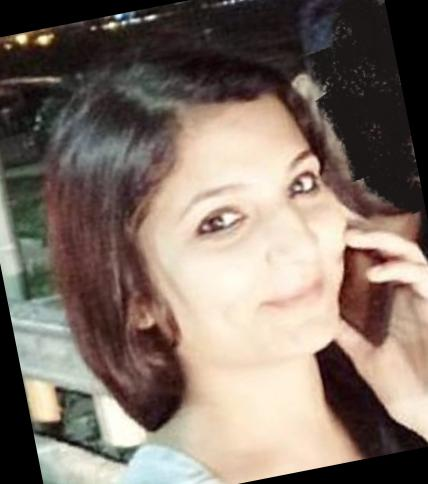

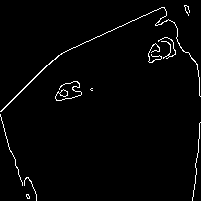

In [ ]:
img = images[977]
cv2_imshow(img)
if_detected, croped = extract_face_final(img)
croped_edge = edge_A(croped)
cv2_imshow(croped_edge)

In [ ]:
def wear_mask_density(img, plot):
  if_detected, croped = extract_face_final(img)
  if not if_detected:
    return 2
  croped_edge = edge_A(croped)
  masked = compare_tb_3(croped_edge,plot)
  return masked

In [ ]:
# test1 = cv2.imread("/content/drive/MyDrive/Voronoi Diagram/2.jpg")
test1 = images[5]
masked = wear_mask_density(test1,True)
print(masked)

In [ ]:
def analyze_density(predicted, labels): 
  correct = 0
  non_detect = []
  wrong_pred = []
  false_positive = []
  false_negative = []

  for i in range(len(predicted)): 
    if predicted[i] == labels[i]:
      correct = correct +1
    else: 
      if predicted[i] == 2:
        non_detect.append(i)
      else:
        wrong_pred.append(i)
        if predicted[i] == 1:
          false_positive.append(i)
        else:
          false_negative.append(i)

  acc = float(correct/len(predicted))

  print('Total cases: ', len(predicted))
  print('Accuracy: ', acc)
  print('NO face detected:', len(non_detect), ',', non_detect)
  print('Wrong prediction:', len(wrong_pred), ',', wrong_pred)
  print('False Positive:', len(false_positive), ',', false_positive)
  print('False Negative:', len(false_negative), ',', false_negative)
  print('Accuracy without non_detection:', correct/(len(predicted)-len(non_detect)))

  return wrong_pred

In [ ]:
images, count_mask = load_img(masked_dir, unmasked_dir, 500)
labels = get_labels(images, count_mask)

In [ ]:
predicted_B = []
for each in images:
  predicted_B.append(wear_mask_density(each,False))
wrong_pred = analyze_density(predicted_B,labels)

In [ ]:
wrong_pred = [5, 8]

for i in wrong_pred:
  cv2_imshow(images[i])
  pred = wear_mask_density(images[i],True)
  print(i,pred,labels[i])

## C. Machine Learning


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

#save the image(i) in the same directory
test_img = img

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
  conv_img = cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),2)
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = test_img[y:y+h, x:x+w]
  eyes = eye_cascade.detectMultiScale(roi_gray)
  total = []
  for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

cv2_imshow(test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Other

In [ ]:
# Delaunay triangulation
# im_bw for binary image, 
# face_image_1 for extracted face

choice = face_image_1

rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)
for t in triangles:
   pt1 = (t[0], t[1])
   pt2 = (t[2], t[3])
   pt3 = (t[4], t[5])
   cv2.line(choice, pt1, pt2, (0, 0, 255), 2)
   cv2.line(choice, pt2, pt3, (0, 0, 255), 2)
   cv2.line(choice, pt1, pt3, (0, 0, 255), 2)

cv2_imshow(choice)

In [ ]:
img_gray = cv2.cvtColor(face_image_1, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

faces = detector(im_bw)
for face in faces:
    landmarks = predictor(im_bw, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    #cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(im_bw, convexhull, 255)

cv2_imshow(im_bw)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Delaunay triangulation
# im_bw for binary image, 
# face_image_1 for extracted face

choice = im_bw

rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)
for t in triangles:
   pt1 = (t[0], t[1])
   pt2 = (t[2], t[3])
   pt3 = (t[4], t[5])
   cv2.line(choice, pt1, pt2, (0, 0, 255), 2)
   cv2.line(choice, pt2, pt3, (0, 0, 255), 2)
   cv2.line(choice, pt1, pt3, (0, 0, 255), 2)

cv2_imshow(choice)

In [ ]:
import matplotlib.pyplot as plt

x=['Image Cropping','Edge detection','Delaunay Triangle','Final']
orig=[65.1, 76.8, 77.4, None]
impr=[76.8, 86.5, 77.4, 86.5]
plt.plot(x,orig,label='Original Accuracy',x,impr, label='Improved Accuracy')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Accuracy Imporvement')
plt.show()

SyntaxError: ignored